## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This is a [fork](https://github.com/mas-dse-greina/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb) of O'Shea, Corgan, and Clancy's Python Notebook.

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

In [1]:
filepath = 'convmodrecnets_CNN2_Tony6'

In [2]:
# Standard python imports
import os,random
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle, sys, os
%matplotlib inline
#!jt -t grade3
#!jt -r # reset themes

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import GaussianNoise, LSTM
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [4]:
tf.keras.backend.clear_session()

In [5]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
#import os
data_dir_path = "/userhomes/jal77/amc_study/data/";
Xd = pickle.load(open(os.path.join(data_dir_path, "RML2016.10a_dict.pkl"),'rb'), encoding='latin1')

In [6]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
print(len(Xd[list(Xd.keys())[0]]))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
plt.ioff()
path = os.path.join(os.getcwd())
signals = X
plt.show()

1000


In [7]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### Radio frequency (RF) signals

Once we've specified the dictionary key (e.g. ['QAM64', 4] for QAM64 modulation @ 4 dB SNR), then we'll be left with the following matrix.

In [8]:
np.shape(Xd['QAM64', 0])

(1000, 2, 128)

+ The first dimension represents the 1,000 sampled windows (each window has the 128 I & Q samples)
+ The second dimension represents the two components ([I & Q](https://youtu.be/h_7d-m1ehoY)) of the RF signal. 
+ The third dimension represents the 128 samples in time (1 MHz so 1 $\mu$s per index)

### Now we need to append all of the modulation, SNR, samples, channels, and time points into one big matrix to pass into our neural net.

So there will be 220,000 samples. Each sample is 2 x 128. The 2 are the I and Q channels. The 128 are the 128 time samples of the waveform (sampled at 1 MHz).

In [9]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [10]:
np.shape(X)

(220000, 2, 128)

## Add noise class to dataset

So let's just add 2 channels of random Gaussian noise to see if we can give the network an option to pick if it can't decide between the true modulations. This is basically an "I don't know" classification.

In [11]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples): 
    lbl.append(['Noise', snrs[i%len(snrs)]])
    
mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

In [12]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) # Convert from list to numpy array (for speed)

y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

## Split into a training and testing set

It's crucial that we split the data into at least 2 sets. One set (called the training set) will be used to train the neural network. That is, the weights of the neural network will be adjusted to make the best possible prediction of the training data. However, if we just stopped there, then we'd have a model that was good at predicting things it already knew the answers to. We want to ensure that the model can predict things it has never seen before. So we save some data (usually about 1/4 to 1/3) to test whether the trained neural network can be just as accurate on data it has never seen.

Most decent machine learning toolkits contain a method to randomly split your data into these two sets. We typically use the one from sklearn (train_test_split). However, we want to keep track of the indices so that we can also get the SNRs at the end. So we'll just use a random array to split the two groups.

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)  

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [14]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [15]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods

(168000, 2, 128) [2, 128]


# Build the NN Model

In [16]:
def build_model(in_shp):
    # Build VT-CNN2 Neural Net model using Keras primitives
    #  - Reshape [N,2,128] to [N,1,2,128] on input
    #  - Pass through 3 2DConv/ReLu layers
    #  - Pass through 2 Dense layers (ReLu and Softmax)
    #  - Perform categorical cross entropy optimization

    dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
    model = models.Sequential()  # Neural network is a set of sequential layers

    model.add(Reshape(in_shp+[1], input_shape=in_shp))  

    # #model.add(ZeroPadding2D((0, 2)))  # Add 2 columns of zeros to each side
    model.add(Convolution2D(16, (1, 16), padding='valid', strides=(1,2), activation="relu", name="conv1", kernel_initializer='glorot_uniform'))

    #model.add(MaxPooling2D(pool_size=(1, 2)))

    # #model.add(ZeroPadding2D((0, 2))) # Add 2 columns of zeros to each side
    model.add(Convolution2D(32, (2, 8), padding="valid", strides=(1,2),activation="relu", name="conv2", kernel_initializer='glorot_uniform'))

    #model.add(MaxPooling2D(pool_size=(1, 2)))

    # #model.add(ZeroPadding2D((0, 2))) # Add 2 columns of zeros to each side
    model.add(Convolution2D(64, (1, 4), padding="valid", activation="relu", name="conv3", kernel_initializer='glorot_uniform'))

    #model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(512, kernel_initializer="he_normal", activation="relu", name="dense1"))

    model.add(Dropout(dr))

    model.add(Dense(256, kernel_initializer="he_normal", activation="relu", name="dense2"))

    model.add(Dropout(dr))

    model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense3" ))

    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [17]:
# Set up some params 
nb_epoch = 150     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [18]:
# Check if there is a previous weights file and load it if it exists.
# This will allows us to resume from where we left off.
model = build_model(in_shp)
import os
if os.path.exists(filepath + '.wts.h5'):
    MODEL_EXISTS = 1;
    model.load_weights(filepath + '.wts.h5')
    print(model)
else:
    MODEL_EXISTS = 0;
    
    # perform training ...
    #   - call the main training loop in keras for our network+dataset

    modelWeightsFile = filepath + '.wts.h5'  # Save the model weights to this file

    history = model.fit(X_train,
        Y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        verbose=2,
        validation_data=(X_test, Y_test),
        callbacks = [
            keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
        ])

    # we re-load the best weights once training is finished
    model.load_weights(modelWeightsFile)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 57, 16)         272       
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 25, 32)         8224      
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 22, 64)         8256      
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               721408    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

Epoch 34/150

Epoch 00034: val_loss did not improve from 1.10137
165/165 - 1s - loss: 1.1181 - accuracy: 0.5705 - val_loss: 1.1050 - val_accuracy: 0.5721
Epoch 35/150

Epoch 00035: val_loss improved from 1.10137 to 1.09759, saving model to convmodrecnets_CNN2_Tony6.wts.h5
165/165 - 1s - loss: 1.1090 - accuracy: 0.5744 - val_loss: 1.0976 - val_accuracy: 0.5796
Epoch 36/150

Epoch 00036: val_loss did not improve from 1.09759
165/165 - 1s - loss: 1.1058 - accuracy: 0.5756 - val_loss: 1.1051 - val_accuracy: 0.5767
Epoch 37/150

Epoch 00037: val_loss did not improve from 1.09759
165/165 - 1s - loss: 1.1037 - accuracy: 0.5755 - val_loss: 1.1081 - val_accuracy: 0.5697
Epoch 38/150

Epoch 00038: val_loss did not improve from 1.09759
165/165 - 1s - loss: 1.0996 - accuracy: 0.5777 - val_loss: 1.1149 - val_accuracy: 0.5771
Epoch 39/150

Epoch 00039: val_loss did not improve from 1.09759
165/165 - 1s - loss: 1.1018 - accuracy: 0.5780 - val_loss: 1.1207 - val_accuracy: 0.5728
Epoch 40/150

Epoch 00

# Evaluate and Plot Model Performance

In [19]:
from sklearn.metrics import classification_report
y_predict = model.predict_classes(X_test)
print()
print()
print(classification_report(np.argmax(Y_test, axis=1), y_predict))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


              precision    recall  f1-score   support

           0       0.72      0.52      0.60      5957
           1       0.53      0.71      0.61      5852
           2       0.26      0.95      0.41      5932
           3       0.80      0.60      0.69      6051
           4       0.87      0.61      0.71      5963
           5       0.82      0.63      0.72      6022
           6       1.00      1.00      1.00      6125
           7       0.88      0.68      0.76      5991
           8       0.41      0.16      0.23      5906
           9       0.54      0.63      0.58      6029
          10       0.86      0.52      0.65      6072
          11   

In [20]:
#print(classification_report(np.argmax(model.predict(Y_test), axis=-1))
# np.argmax(model.predict(Y_test), axis=1)

## Loss curves

Loss curves show us how well the training went. They also allow us to detect over-training of the model. If the model is over-trained, then it might not generalize well. Often, in an over-trained model, the training loss (error) will continually decrease while the validation (test error) will decrease and then begin to increase again with successive training epochs.

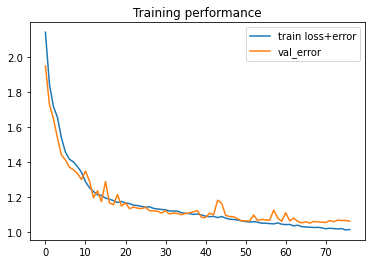

In [21]:
if MODEL_EXISTS != 1:
    # Show loss curves 
    plt.figure();
    plt.title('Training performance');
    plt.plot(history.epoch, history.history['loss'], label='train loss+error');
    plt.plot(history.epoch, history.history['val_loss'], label='val_error');
    plt.legend();
    plt.show()

# Confusion Matrix

A confusion matrix is a great way to see where the model (neural network) had trouble. It plots the number of times the model predicted a modulation versus the actual modulation (predicted versus true).

In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

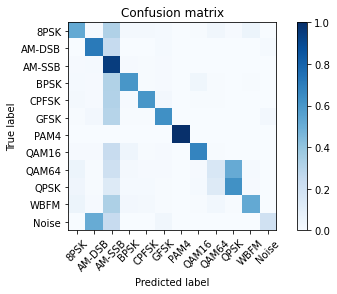

In [23]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
plt.show()


## In general, the model had a difficult time predicting AM-DSB modulation. Otherwise, it did a decent job at predicting the correct modulation.

Overall Accuracy for SNR -20: 0.16876222408493993
Overall Accuracy for SNR -18: 0.17474383827194684
Overall Accuracy for SNR -16: 0.1740912817709757
Overall Accuracy for SNR -14: 0.18294701986754966
Overall Accuracy for SNR -12: 0.20974808324205915
Overall Accuracy for SNR -10: 0.28269126424308194
Overall Accuracy for SNR -8: 0.42493638676844786
Overall Accuracy for SNR -6: 0.5572348166806605
Overall Accuracy for SNR -4: 0.6659224113871057
Overall Accuracy for SNR -2: 0.7446221731936018
Overall Accuracy for SNR 0: 0.798993570030752
Overall Accuracy for SNR 2: 0.835063113604488
Overall Accuracy for SNR 4: 0.8492616327667875
Overall Accuracy for SNR 6: 0.8542241855328547
Overall Accuracy for SNR 8: 0.850712887894884
Overall Accuracy for SNR 10: 0.8587257617728532
Overall Accuracy for SNR 12: 0.8472533632286996
Overall Accuracy for SNR 14: 0.8526019690576653
Overall Accuracy for SNR 16: 0.8437758763455699
Overall Accuracy for SNR 18: 0.8551897321428571


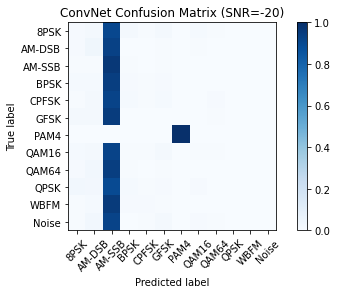

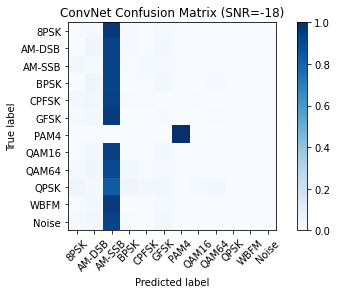

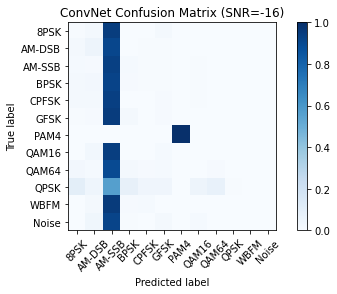

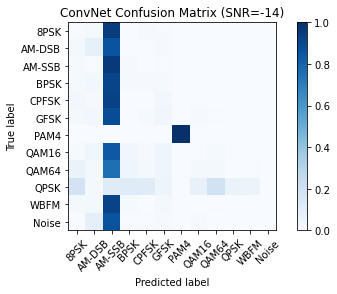

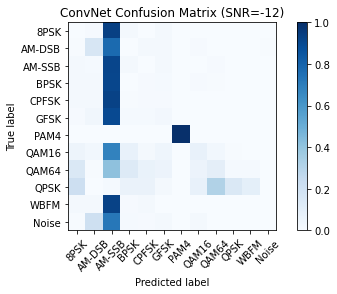

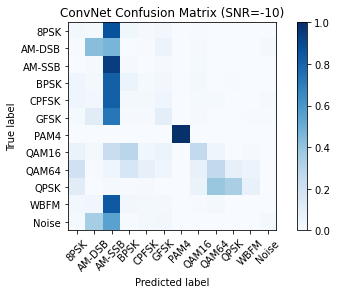

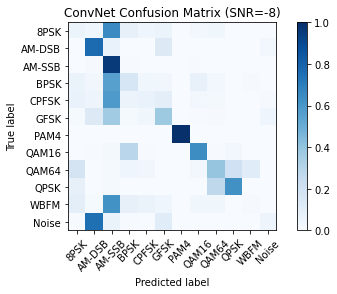

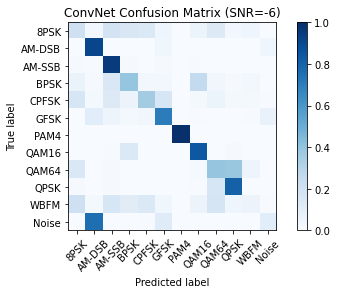

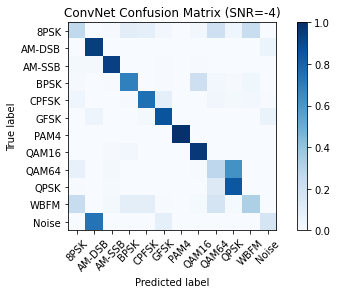

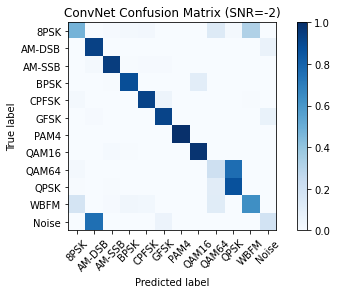

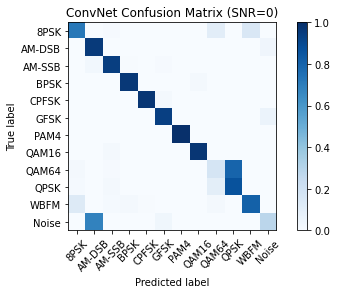

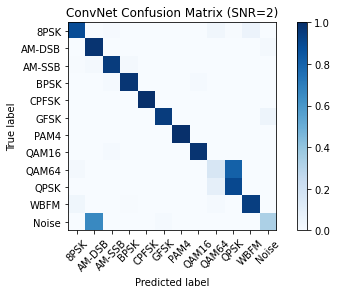

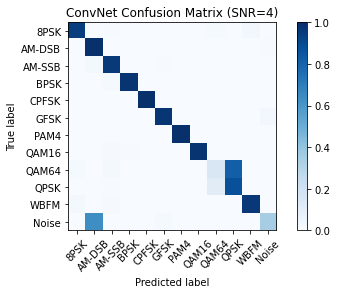

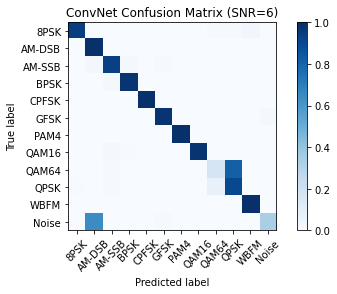

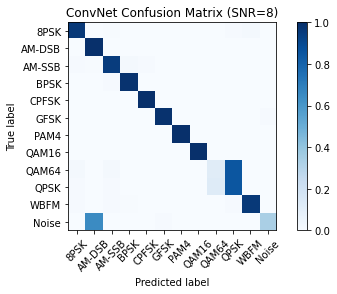

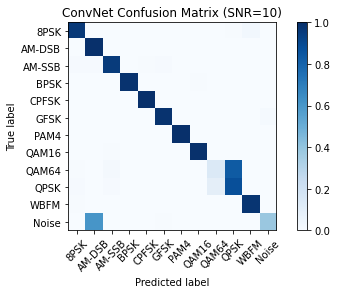

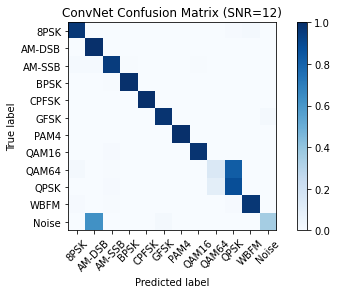

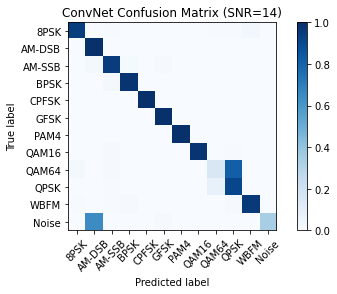

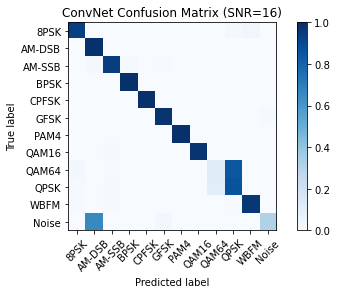

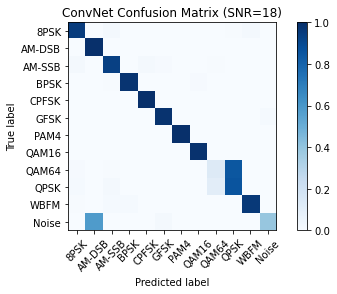

In [24]:
import pdb

# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    #pdb.set_trace();
    test_SNRs = list(map(lambda x: int(lbl[x][1]), test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)
    
plt.show()

In [25]:
#a = lambda x: int(lbl[x][1])
#a
# test_idx
#list(map(lambda x: int(lbl[x][1]), test_idx))

In [26]:
# Save results to a pickle file for plotting later
print(acc)
fd = open(filepath + '.results.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.16876222408493993, -18: 0.17474383827194684, -16: 0.1740912817709757, -14: 0.18294701986754966, -12: 0.20974808324205915, -10: 0.28269126424308194, -8: 0.42493638676844786, -6: 0.5572348166806605, -4: 0.6659224113871057, -2: 0.7446221731936018, 0: 0.798993570030752, 2: 0.835063113604488, 4: 0.8492616327667875, 6: 0.8542241855328547, 8: 0.850712887894884, 10: 0.8587257617728532, 12: 0.8472533632286996, 14: 0.8526019690576653, 16: 0.8437758763455699, 18: 0.8551897321428571}


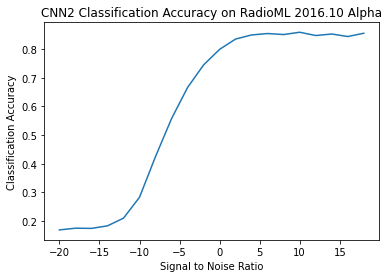

In [27]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");
plt.show()